# I. Prepare data

In [1]:
from lxml import etree
import nltk, os, sys, time
import numpy as np
from numpy.linalg import norm
import pandas as pd
from tqdm import tqdm
import cPickle as pk
np.random.seed(1) # to be reproducible

W2V_FPATH = '/local/XW/DATA/WORD_EMBEDDINGS/biomed-w2v-200.txt'
GLOVE_FPATH = '/local/XW/DATA/WORD_EMBEDDINGS/glove.6B.200d.txt'
WD_PLACEHOLDER = '</s>'

In [17]:
topic_tree = etree.parse('data/topics2016.xml')

def get_topic_desc(i):# returns the description string of the ith topic
    summary = topic_tree.xpath('//topic[@number="%d"]/description/text()'%i)[0]
    return (u''+summary).lower()

In [2]:
# build a mapping of article name (PMCID) to its file path

PMC_PATH = '/local/XW/DATA/TREC/PMCs/'
pmcid2fpath = {}

for subdir1 in os.listdir(PMC_PATH):
    for subdir2 in os.listdir(os.path.join(PMC_PATH, subdir1)):
        diry = os.path.join(PMC_PATH, subdir1, subdir2)
        for fn in os.listdir(diry):
            pmcid = fn[:-5]
            fpath = os.path.join(diry, fn)
            pmcid2fpath[pmcid] = fpath

def get_article_abstract(pmcid):
    fpath = pmcid2fpath[pmcid]
    tree = etree.parse(fpath)
    ret = u'' + tree.xpath('string(//article-title)') + '\n'
    abstracts = tree.xpath('//abstract')
#     abstracts = tree.xpath('//p')
    ret += u' '.join( [abstract.xpath('string(.)') for abstract in abstracts] )
    if len(ret.split())<20: 
        raise Exception(u'abstraction too short: '+pmcid + ret)
    return ret.lower()

In [9]:
corpus = []
pmcid_2relevance = [{} for i in xrange(31)] # list of dict mapping pmcid to relevance
with open('data/qrels.txt') as f:
    for line in tqdm(f, total=37707): 
        topicid, _, pmcid, relevance = line.split()
        topicid = int(topicid)
        try:
            corpus.append(get_article_abstract(pmcid)) # !some articles don't have an abstract!
            pmcid_2relevance[topicid][pmcid] = int(relevance)
        except: 
            pass

100%|██████████| 37707/37707 [02:01<00:00, 310.52it/s]


In [10]:
print '%d articles are retrieved' % len(corpus)

34601 articles are retrieved


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectorizer.fit_transform(corpus)
vocab = set(vectorizer.vocabulary_.keys())

In [12]:
def get_idf(wd):
    if wd ==WD_PLACEHOLDER: return -1e10
    return vectorizer.idf_[ vectorizer.vocabulary_[wd] ]

In [13]:
word2vec = {} # maps word ---> embedding vector
with open(W2V_FPATH) as f:
    for line in tqdm(f, total=5443657): # 5443657 400000
        vals = line.split()
        word = vals[0]
        if word in vocab:
            vec = np.asarray(vals[1:], dtype='float')
            word2vec[word] = vec
print 'found %d word vectors.' % len(word2vec)

100%|██████████| 5443657/5443657 [01:18<00:00, 69255.14it/s]

found 58989 word vectors.


In [14]:
from nltk.corpus import stopwords
stopwds = set(stopwords.words('english'))

In [18]:
_queries = [get_topic_desc(i) for i in xrange(1,31)] 
QUERIES = []
for q in _queries:
    q2 = [wd for wd in q.split() if (wd not in stopwds) and (wd in word2vec)] # filter out stopword and words not in w2v
    QUERIES.append(q2)

In [19]:
print map(len, QUERIES)

[20, 18, 63, 46, 23, 47, 98, 52, 74, 48, 43, 33, 46, 54, 63, 44, 36, 65, 51, 61, 69, 27, 34, 50, 71, 85, 46, 44, 111, 51]


In [20]:
N = max(map(len, QUERIES)) # = max query length
print N

111


In [21]:
# padding queries to the same length N
WD_PLACEHOLDER = '</s>'
def pad_query(q, SZ=N):
    return q + [WD_PLACEHOLDER]*(SZ-len(q))
QUERIES = map(pad_query, QUERIES)

## helper functions

In [22]:
def get_histvec(q_wd, doc):
    if q_wd == WD_PLACEHOLDER: 
        return np.zeros(30)
    qvec = word2vec[q_wd]
#     dvecs = np.vstack( [word2vec.get(wd, randvec) for wd in nltk.word_tokenize(doc)] )
    dvecs = np.vstack( [ word2vec[wd] for wd in nltk.word_tokenize(doc) if wd in word2vec] )
    cossims = np.dot(dvecs, qvec) / norm(qvec) / norm(dvecs, axis=1)
    hist, _ = np.histogram( cossims[cossims<1.0], bins=29, range=(-1,1) )
    ones = len(cossims) - sum(hist)
    ret = np.array( list(hist) + [ones] )
    ret = np.log(ret+1)
    return ret # np.reshape(ret, (-1, 30))

In [23]:
def get_query_doc_feature(query, pmcid): # query: list of words
    doc = get_article_abstract(pmcid)
    return np.array([ get_histvec(wd, doc) for wd in query])

### prepare data

In [24]:
T = 30 # nubmer of used topics

In [25]:
pos_ids, neg_ids = [], [] # pos_ids[q] is a list (positive pmcids for query `q`)
hists_pos, hists_neg = [], [] # hists_pos[q] is a list (positive hists for query `q`)
                              # hists_pos[q][i] is an array of size N*30 (the ith hists-feature array for query q)
for topic in xrange(1,T+1):
    query = QUERIES[topic-1]
    pos_ids_q, neg_ids_q = [], []
    hists_pos_q, hists_neg_q = [], []
    relevance = pmcid_2relevance[topic]
    for pmcid in tqdm(relevance.keys()):
        if relevance[pmcid]==0: 
            neg_ids_q.append(pmcid)
            hists_neg_q.append(get_query_doc_feature(query,pmcid))
        else: 
            pos_ids_q.append(pmcid)
            hists_pos_q.append(get_query_doc_feature(query,pmcid))
    hists_pos_q, hists_neg_q = map(np.array, [hists_pos_q, hists_neg_q])
    hists_pos.append(hists_pos_q); hists_neg.append(hists_neg_q)
    pos_ids.append(pos_ids_q); neg_ids.append(neg_ids_q)
print len(pos_ids), len(neg_ids)

100%|██████████| 1237/1237 [07:51<00:00,  3.17it/s]

30 30


In [26]:
print map(len, hists_pos)
print map(len, hists_neg)

[125, 34, 144, 18, 95, 133, 68, 809, 117, 19, 350, 107, 128, 117, 69, 175, 171, 63, 204, 616, 68, 8, 108, 714, 213, 103, 12, 203, 118, 34]
[1215, 1162, 1209, 1310, 1289, 692, 997, 318, 984, 1079, 604, 1051, 1208, 1021, 954, 1266, 863, 1016, 942, 406, 865, 1102, 1444, 617, 880, 858, 916, 1367, 620, 1203]


### prepare generator

In [27]:
VALDATION_SPLIT = 0.2
BATCH_SZ = 128
NB_EPOCH = 50

In [28]:
idx_pairs = [] # list of list, where idx_pairs[q] is a list of tuples of the form: `(q, pos_idx, neg_idx)` for query q
for q in xrange(T):
    hists_pos_q, hists_neg_q = hists_pos[q], hists_neg[q]
    idx_pairs_q = []
    for pidx in xrange(len(hists_pos_q)): # here the idx are just row index in hists array
        for nidx in xrange(len(hists_neg_q)):
            idx_pairs_q.append( (q, pidx, nidx) )
    idx_pairs.append(idx_pairs_q)

n_val_queries = int(T * VALDATION_SPLIT)
idx_pairs_train = reduce( lambda x,y: x+y, idx_pairs[:-n_val_queries] )
idx_pairs_val   = reduce( lambda x,y: x+y, idx_pairs[-n_val_queries:] )

idx_pairs_train, idx_pairs_val = map(np.array, [idx_pairs_train, idx_pairs_val])

print idx_pairs_train.shape, idx_pairs_val.shape

(3267522, 3) (678369, 3)


In [29]:
IDFs = [ np.array ([ get_idf(wd) for wd in query]) for query in QUERIES]
IDFs = np.array(IDFs)

In [30]:
def batch_generator(idx_pairs, batch_size=BATCH_SZ): 
    np.random.shuffle(idx_pairs)
    batches_pre_epoch = len(idx_pairs) // batch_size
    samples_per_epoch = batches_pre_epoch * batch_size # make samples_per_epoch a multiple of batch size
    counter = 0
    y_true_batch_dummy = np.ones((batch_size))
    while 1:
        idx_batch = idx_pairs[batch_size*counter: min(samples_per_epoch, batch_size*(counter+1))]
        idfs_batch, pos_batch, neg_batch = [], [], []
        for q, pidx, nidx in idx_batch:
            idfs_batch.append(IDFs[q])
            pos_batch.append(hists_pos[q][pidx])
            neg_batch.append(hists_neg[q][nidx])
        idfs_batch, pos_batch, neg_batch = map(np.array, [idfs_batch, pos_batch, neg_batch])
#         print idfs_batch.shape, pos_batch.shape, neg_batch.shape
        counter += 1
        if (counter >= batches_pre_epoch):
            np.random.shuffle(idx_pairs)
            counter=0
        
        yield [idfs_batch, pos_batch, neg_batch], y_true_batch_dummy

# II. Define the deep relevance model

In [31]:
# define a function for visualization of model
import pydot
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot
def viz_model(model):
    return SVG(model_to_dot(model).create(prog='dot', format='svg'))

Using TensorFlow backend.


### construct the relevance IR model

In [32]:
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, InputLayer, Flatten, Input, Merge, merge, Reshape
import keras.backend as K
from keras.callbacks import EarlyStopping, TensorBoard
import tensorflow as tf

In [33]:
# 2 main components of the structure: feed forward network and gating
feed_forward = Sequential(
    [Dense(input_dim=30, output_dim=10, activation='relu', bias=False),
     Dense(output_dim=5, activation='relu', bias=False),
     Dense(output_dim=1, activation='tanh', bias=False)], 
    name='feed_forward_nw')

# ***note: have to wrap ops into Lambda layers !!***
# cf: https://groups.google.com/forum/#!topic/keras-users/fbRS-FkZw_Q
from keras.layers.core import Lambda

input_idf = Input(shape=(N,), name='input_idf')
def scale(x): 
    w = K.variable(1, name='w_g')
    return tf.mul(x,w)
def scale_output_shape(input_shape): return input_shape

scaled = Lambda(scale, scale_output_shape, name='softmax_scale')(input_idf)
gs_out = Activation('softmax', name='softmax')(scaled)
gating = Model(input=input_idf, output=gs_out, name='gating')

# first input: hist vectors
input_hists = Input(shape=(N,30), name='input_hists')

def slicei(x, i): return x[:,i,:]
def slicei_output_shape(input_shape): return (input_shape[0], input_shape[2])
zs = [ feed_forward( Lambda(lambda x:slicei(x,i), slicei_output_shape, name='slice%d'%i)(input_hists) )\
          for i in xrange(N) ]

def concat(x): return K.concatenate(x) 
def concat_output_shape(input_shape): return (input_shape[0][0], N)
zs = Lambda(concat, concat_output_shape, name='concat_zs')(zs)

# second input: idf scores of each query term 
input_idf = Input(shape=(N,), name='input_idf')
gs = gating(input_idf)

def innerprod(x): return K.sum( tf.mul(x[0],x[1]), axis=1)
def innerprod_output_shape(input_shape): return (input_shape[0][0],1)
scores = Lambda(innerprod, innerprod_output_shape, name='innerprod_zs_gs')([zs, gs])

scoring_model = Model(input=[input_idf, input_hists], output=[scores], name='scoring_model')

# third input -- the negative hists vector 
input_hists_neg = Input(shape=(N,30), name='input_hists_neg')

zs_neg = [ feed_forward( Lambda(lambda x:slicei(x,i), slicei_output_shape, name='slice%d_neg'%i)(input_hists_neg) )\
          for i in xrange(N) ]

zs_neg = Lambda(concat, concat_output_shape, name='concat_zs_neg')(zs_neg)

scores_neg = Lambda(innerprod, innerprod_output_shape, name='innerprod_zs_gs_neg')([zs_neg, gs])

two_score_model = Model(input=[input_idf, input_hists, input_hists_neg], 
                        output=[scores, scores_neg], 
                        name='two_score_model')

def diff(x): return tf.sub(x[0], x[1]) #x[0]-x[1]
def diff_output_shape(input_shape): return input_shape[0]
posneg_score_diff = Lambda(diff, diff_output_shape, name='posneg_score_diff')([scores, scores_neg])
ranking_model = Model(input=[input_idf, input_hists,  input_hists_neg]
                      , output=[posneg_score_diff]
                      , name='ranking_model')

# define my loss function: hinge of score_pos - score_neg
def pairwise_hinge(y_true, y_pred): # y_pred = score_pos - score_neg, **y_true doesn't matter here**
    return K.mean( K.maximum(1. - y_pred, y_true*0.0) )  

# self-defined metrics
def ranking_acc(y_true, y_pred):
    y_pred = y_pred > 0 
    return K.mean(y_pred)

ranking_model.compile(optimizer='adagrad', loss=pairwise_hinge, metrics=[ranking_acc])

In [34]:
initial_weights = ranking_model.get_weights()

In [35]:
gating.predict(IDFs[0].reshape(-1,N))

array([[ 0.0040956 ,  0.00775904,  0.01263875,  0.00355943,  0.35950226,
         0.08744649,  0.03052377,  0.00140675,  0.00343838,  0.23110865,
         0.01159685,  0.01685167,  0.00382902,  0.04493778,  0.07891513,
         0.01807553,  0.07703622,  0.00069298,  0.00186916,  0.0047165 ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

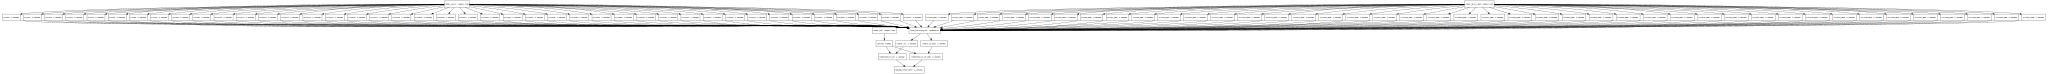

In [61]:
viz_model(ranking_model)

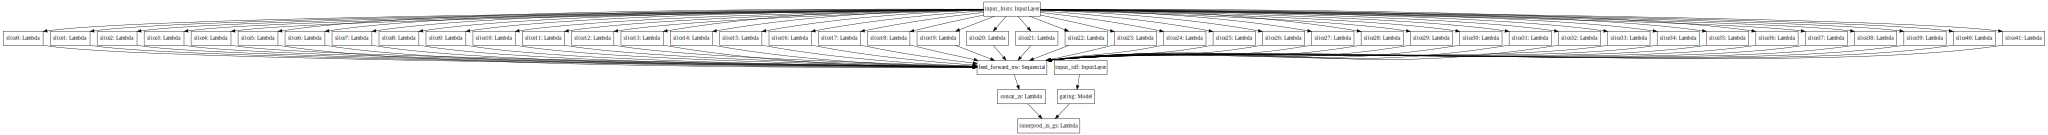

In [62]:
viz_model(scoring_model)

# III. train model

In [36]:
querypmc2histvec = {} # mapping from (query_idx, pmcid) to the corresponding input vectors (idf_input, hist_input) tuple

In [37]:
for q in tqdm(xrange(30)):
    query = QUERIES[q]
    for pmcid in pmcid_2relevance[q+1].keys():
        _idf = IDFs[q].reshape(-1,N)
        _hist = get_query_doc_feature(query, pmcid).reshape(1,N,30)
        querypmc2histvec[(q, pmcid)] = (_idf, _hist)

100%|██████████| 30/30 [3:29:12<00:00, 466.32s/it]


In [38]:
data_to_pickle = {
    'querypmc2histvec': querypmc2histvec,
    'hists_pos': hists_pos,
    'hists_neg': hists_neg,
    'pos_ids': pos_ids,
    'neg_ids': neg_ids,
    'pmcid_2relevance': pmcid_2relevance,
    'corpus': corpus,
    'word2vec': word2vec
}
with open('data/IRdata.pk', 'wb') as f:
    pk.dump(data_to_pickle, f, pk.HIGHEST_PROTOCOL)

## train model using `fit_generator`

In [39]:
logdir = './logs/relevance_matching'
_callbacks = [ EarlyStopping(monitor='val_loss', patience=2),
               TensorBoard(log_dir=logdir, histogram_freq=0, write_graph=False) ]

In [28]:
# 30-5-1 tanh
ranking_model.fit_generator( batch_generator(idx_pairs_train), 
                    samples_per_epoch = len(idx_pairs_train)//BATCH_SZ*BATCH_SZ,
                    nb_epoch=NB_EPOCH,
                    validation_data=batch_generator(idx_pairs_val),
                    nb_val_samples=len(idx_pairs_val)//BATCH_SZ*BATCH_SZ, 
                    callbacks = _callbacks)

Epoch 1/50
3267456/3267456 [==============================] - 202s - loss: 0.9046 - ranking_acc: 0.5778 - val_loss: 0.9763 - val_ranking_acc: 0.5424
Epoch 2/50
3267456/3267456 [==============================] - 198s - loss: 0.8813 - ranking_acc: 0.5945 - val_loss: 0.9882 - val_ranking_acc: 0.5258
Epoch 3/50
3267456/3267456 [==============================] - 199s - loss: 0.8742 - ranking_acc: 0.5983 - val_loss: 0.9905 - val_ranking_acc: 0.5246
Epoch 4/50
3267456/3267456 [==============================] - 203s - loss: 0.8709 - ranking_acc: 0.5999 - val_loss: 0.9927 - val_ranking_acc: 0.5237


In [42]:
gating.predict(IDFs[0].reshape(-1,N))

array([[ 0.13057594,  0.00933529,  0.01021741,  0.02965928,  0.10123158,
         0.07826629,  0.64071429,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ]], dtype=float32)

In [40]:
def shuffle_weights(model, weights=None):
    """Randomly permute the weights in `model`, or the given `weights`.
    This is a fast approximation of re-initializing the weights of a model.
    Assumes weights are distributed independently of the dimensions of the weight tensors
      (i.e., the weights have the same distribution along each dimension).
    :param Model model: Modify the weights of the given model.
    :param list(ndarray) weights: The model's weights will be replaced by a random permutation of these weights.
      If `None`, permute the model's current weights.
    """
    if weights is None:
        weights = model.get_weights()
    weights = [np.random.permutation(w.flat).reshape(w.shape) for w in weights]
    model.set_weights(weights)

In [41]:
def TREC_output(topic_id, pmcids, run_name = 'my_run', fpath = None):
    query = QUERIES[topic_id]
    res = [] # list of (score, pmcid) tuples
    for pmcid in tqdm(pmcids):
        input_idf, input_hist = querypmc2histvec[(topic_id,pmcid)] # get_query_doc_feature(query, pmcid).reshape(1,N,30)
        score = scoring_model.predict([input_idf, input_hist])[0]
        res.append( (score, pmcid) )
    res = sorted(res, reverse=True)
#     print res[:10]
    fout = sys.stdout if fpath==None else open(fpath, 'a')
    for rank, (score, pmcid) in enumerate(res[:1000],1):
        print >>fout, '%d  Q0  %s  %d  %f  %s' % (topic_id+1, pmcid, rank, score, run_name)

In [42]:
def LOO(fpath):
    for q in xrange(30):
        print '### loo for topic %d ###' % (q+1)
        shuffle_weights(ranking_model, initial_weights)
        idx_pairs_train = reduce( lambda x,y: x+y, idx_pairs[:q]+idx_pairs[q+1:] )
        idx_pairs_val   = idx_pairs[q]
        ranking_model.fit_generator( batch_generator(idx_pairs_train), 
                    samples_per_epoch = len(idx_pairs_train)//BATCH_SZ*BATCH_SZ,
                    nb_epoch=20,
                    validation_data=batch_generator(idx_pairs_val),
                    nb_val_samples=len(idx_pairs_val)//BATCH_SZ*BATCH_SZ, 
                    callbacks = _callbacks)
        sys.stderr.flush()
        TREC_output(q, pmcid_2relevance[q+1].keys(), fpath=fpath)

In [43]:
fpath = '/local/SOFT/Trec_eval/my_run_desc_loo.txt'
open(fpath, 'w').close() # clear previous content of the file
LOO(fpath)

### loo for topic 1 ###
Epoch 1/20
3793920/3793920 [==============================] - 652s - loss: 0.9250 - ranking_acc: 0.5713 - val_loss: 1.0072 - val_ranking_acc: 0.4946
Epoch 2/20
3793920/3793920 [==============================] - 644s - loss: 0.9113 - ranking_acc: 0.5794 - val_loss: 0.9923 - val_ranking_acc: 0.5101
Epoch 3/20
3793920/3793920 [==============================] - 642s - loss: 0.9069 - ranking_acc: 0.5825 - val_loss: 0.9782 - val_ranking_acc: 0.5216
Epoch 4/20
3793920/3793920 [==============================] - 644s - loss: 0.9036 - ranking_acc: 0.5853 - val_loss: 0.9691 - val_ranking_acc: 0.5276
Epoch 5/20
3793920/3793920 [==============================] - 647s - loss: 0.9007 - ranking_acc: 0.5879 - val_loss: 0.9624 - val_ranking_acc: 0.5332
Epoch 6/20
3793920/3793920 [==============================] - 652s - loss: 0.8980 - ranking_acc: 0.5901 - val_loss: 0.9603 - val_ranking_acc: 0.5347
Epoch 7/20
3793920/3793920 [==============================] - 656s - loss: 0.8958 

  0%|          | 1/1340 [00:00<03:53,  5.73it/s]

100%|██████████| 1340/1340 [00:02<00:00, 528.25it/s]


### loo for topic 2 ###
Epoch 1/20
3906304/3906304 [==============================] - 655s - loss: 1.0003 - ranking_acc: 0.4977 - val_loss: 1.0016 - val_ranking_acc: 0.4845
Epoch 2/20
3906304/3906304 [==============================] - 655s - loss: 0.9836 - ranking_acc: 0.5185 - val_loss: 0.9651 - val_ranking_acc: 0.5830
Epoch 3/20
3906304/3906304 [==============================] - 655s - loss: 0.9666 - ranking_acc: 0.5370 - val_loss: 0.9614 - val_ranking_acc: 0.6071
Epoch 4/20
3906304/3906304 [==============================] - 655s - loss: 0.9596 - ranking_acc: 0.5421 - val_loss: 0.9621 - val_ranking_acc: 0.6159
Epoch 5/20
3906304/3906304 [==============================] - 660s - loss: 0.9571 - ranking_acc: 0.5445 - val_loss: 0.9587 - val_ranking_acc: 0.6250
Epoch 6/20
3906304/3906304 [==============================] - 665s - loss: 0.9560 - ranking_acc: 0.5461 - val_loss: 0.9538 - val_ranking_acc: 0.6374
Epoch 7/20
3906304/3906304 [==============================] - 665s - loss: 0.9553 

  5%|▌         | 64/1196 [00:00<00:01, 636.34it/s]

100%|██████████| 1196/1196 [00:02<00:00, 581.97it/s]


### loo for topic 3 ###
Epoch 1/20
3771776/3771776 [==============================] - 642s - loss: 0.9855 - ranking_acc: 0.5273 - val_loss: 0.9520 - val_ranking_acc: 0.5621
Epoch 2/20
3771776/3771776 [==============================] - 647s - loss: 0.9687 - ranking_acc: 0.5367 - val_loss: 0.9427 - val_ranking_acc: 0.5618
Epoch 3/20
3771776/3771776 [==============================] - 653s - loss: 0.9602 - ranking_acc: 0.5397 - val_loss: 0.9387 - val_ranking_acc: 0.5620
Epoch 4/20
3771776/3771776 [==============================] - 655s - loss: 0.9556 - ranking_acc: 0.5418 - val_loss: 0.9357 - val_ranking_acc: 0.5630
Epoch 5/20
3771776/3771776 [==============================] - 657s - loss: 0.9529 - ranking_acc: 0.5429 - val_loss: 0.9356 - val_ranking_acc: 0.5610
Epoch 6/20
3771776/3771776 [==============================] - 642s - loss: 0.9511 - ranking_acc: 0.5439 - val_loss: 0.9356 - val_ranking_acc: 0.5604
Epoch 7/20
3771776/3771776 [==============================] - 646s - loss: 0.9497 

  5%|▍         | 61/1353 [00:00<00:02, 600.64it/s]

100%|██████████| 1353/1353 [00:02<00:00, 570.54it/s]


### loo for topic 4 ###
Epoch 1/20
3922304/3922304 [==============================] - 668s - loss: 0.9973 - ranking_acc: 0.5010 - val_loss: 1.0020 - val_ranking_acc: 0.4910
Epoch 2/20
3922304/3922304 [==============================] - 669s - loss: 0.9850 - ranking_acc: 0.5233 - val_loss: 1.0375 - val_ranking_acc: 0.4183
Epoch 3/20
3922304/3922304 [==============================] - 679s - loss: 0.9769 - ranking_acc: 0.5337 - val_loss: 1.0628 - val_ranking_acc: 0.3842
Epoch 4/20
3922304/3922304 [==============================] - 670s - loss: 0.9688 - ranking_acc: 0.5390 - val_loss: 1.0874 - val_ranking_acc: 0.3646

  4%|▍         | 50/1328 [00:00<00:02, 494.93it/s]

100%|██████████| 1328/1328 [00:02<00:00, 540.87it/s]


### loo for topic 5 ###
Epoch 1/20
3823360/3823360 [==============================] - 649s - loss: 0.9936 - ranking_acc: 0.5171 - val_loss: 0.9317 - val_ranking_acc: 0.5773
Epoch 2/20
3823360/3823360 [==============================] - 651s - loss: 0.9861 - ranking_acc: 0.5266 - val_loss: 0.9307 - val_ranking_acc: 0.5655
Epoch 3/20
3823360/3823360 [==============================] - 654s - loss: 0.9814 - ranking_acc: 0.5356 - val_loss: 0.9404 - val_ranking_acc: 0.5579
Epoch 4/20
3823360/3823360 [==============================] - 661s - loss: 0.9760 - ranking_acc: 0.5445 - val_loss: 0.9386 - val_ranking_acc: 0.5618
Epoch 5/20
3823360/3823360 [==============================] - 651s - loss: 0.9693 - ranking_acc: 0.5517 - val_loss: 0.9267 - val_ranking_acc: 0.5732
Epoch 6/20
3823360/3823360 [==============================] - 657s - loss: 0.9618 - ranking_acc: 0.5574 - val_loss: 0.9038 - val_ranking_acc: 0.5919
Epoch 7/20
3823360/3823360 [==============================] - 654s - loss: 0.9544 

  4%|▍         | 59/1384 [00:00<00:02, 586.76it/s]

100%|██████████| 1384/1384 [00:02<00:00, 544.26it/s]


### loo for topic 6 ###
Epoch 1/20
3853824/3853824 [==============================] - 657s - loss: 0.9972 - ranking_acc: 0.5102 - val_loss: 1.0010 - val_ranking_acc: 0.4705
Epoch 2/20
3853824/3853824 [==============================] - 656s - loss: 0.9955 - ranking_acc: 0.5150 - val_loss: 1.0046 - val_ranking_acc: 0.4616
Epoch 3/20
3853824/3853824 [==============================] - 659s - loss: 0.9939 - ranking_acc: 0.5167 - val_loss: 1.0095 - val_ranking_acc: 0.4447
Epoch 4/20
3853824/3853824 [==============================] - 662s - loss: 0.9922 - ranking_acc: 0.5155 - val_loss: 1.0234 - val_ranking_acc: 0.4249

  7%|▋         | 57/825 [00:00<00:01, 569.47it/s]

100%|██████████| 825/825 [00:01<00:00, 542.63it/s]


### loo for topic 7 ###
Epoch 1/20
3878016/3878016 [==============================] - 668s - loss: 0.9873 - ranking_acc: 0.5324 - val_loss: 0.9575 - val_ranking_acc: 0.6233
Epoch 2/20
3878016/3878016 [==============================] - 562s - loss: 0.9754 - ranking_acc: 0.5341 - val_loss: 0.9315 - val_ranking_acc: 0.6308
Epoch 3/20
3878016/3878016 [==============================] - 394s - loss: 0.9661 - ranking_acc: 0.5357 - val_loss: 0.9186 - val_ranking_acc: 0.6288
Epoch 4/20
3878016/3878016 [==============================] - 395s - loss: 0.9598 - ranking_acc: 0.5378 - val_loss: 0.9123 - val_ranking_acc: 0.6274
Epoch 5/20
3878016/3878016 [==============================] - 396s - loss: 0.9558 - ranking_acc: 0.5397 - val_loss: 0.9090 - val_ranking_acc: 0.6253
Epoch 6/20
3878016/3878016 [==============================] - 399s - loss: 0.9532 - ranking_acc: 0.5410 - val_loss: 0.9092 - val_ranking_acc: 0.6224
Epoch 7/20
3878016/3878016 [==============================] - 398s - loss: 0.9514 

 12%|█▏        | 123/1065 [00:00<00:00, 1228.38it/s]

100%|██████████| 1065/1065 [00:00<00:00, 1241.20it/s]


### loo for topic 8 ###
Epoch 1/20
3688576/3688576 [==============================] - 381s - loss: 0.9965 - ranking_acc: 0.5098 - val_loss: 1.0033 - val_ranking_acc: 0.4903
Epoch 2/20
3688576/3688576 [==============================] - 382s - loss: 0.9940 - ranking_acc: 0.5130 - val_loss: 1.0017 - val_ranking_acc: 0.4960
Epoch 3/20
3688576/3688576 [==============================] - 383s - loss: 0.9931 - ranking_acc: 0.5134 - val_loss: 1.0010 - val_ranking_acc: 0.4995
Epoch 4/20
3688576/3688576 [==============================] - 385s - loss: 0.9921 - ranking_acc: 0.5136 - val_loss: 1.0002 - val_ranking_acc: 0.5027
Epoch 5/20
3688576/3688576 [==============================] - 386s - loss: 0.9911 - ranking_acc: 0.5139 - val_loss: 0.9991 - val_ranking_acc: 0.5052
Epoch 6/20
3688576/3688576 [==============================] - 386s - loss: 0.9900 - ranking_acc: 0.5143 - val_loss: 0.9982 - val_ranking_acc: 0.5070
Epoch 7/20
3688576/3688576 [==============================] - 387s - loss: 0.9887 

 11%|█         | 122/1127 [00:00<00:00, 1216.04it/s]

100%|██████████| 1127/1127 [00:00<00:00, 1233.62it/s]


### loo for topic 9 ###
Epoch 1/20
3830656/3830656 [==============================] - 390s - loss: 0.9948 - ranking_acc: 0.5146 - val_loss: 0.9999 - val_ranking_acc: 0.5013
Epoch 2/20
3830656/3830656 [==============================] - 392s - loss: 0.9888 - ranking_acc: 0.5195 - val_loss: 1.0002 - val_ranking_acc: 0.4970
Epoch 3/20
3830656/3830656 [==============================] - 391s - loss: 0.9851 - ranking_acc: 0.5210 - val_loss: 1.0007 - val_ranking_acc: 0.4931
Epoch 4/20
3830656/3830656 [==============================] - 391s - loss: 0.9823 - ranking_acc: 0.5229 - val_loss: 1.0014 - val_ranking_acc: 0.4887

 11%|█▏        | 124/1101 [00:00<00:00, 1230.54it/s]

100%|██████████| 1101/1101 [00:00<00:00, 1237.63it/s]


### loo for topic 10 ###
Epoch 1/20
3925376/3925376 [==============================] - 391s - loss: 0.9968 - ranking_acc: 0.5187 - val_loss: 1.0014 - val_ranking_acc: 0.4591
Epoch 2/20
3925376/3925376 [==============================] - 393s - loss: 0.9938 - ranking_acc: 0.5211 - val_loss: 1.0033 - val_ranking_acc: 0.4604
Epoch 3/20
3925376/3925376 [==============================] - 393s - loss: 0.9893 - ranking_acc: 0.5249 - val_loss: 0.9943 - val_ranking_acc: 0.5160
Epoch 4/20
3925376/3925376 [==============================] - 396s - loss: 0.9843 - ranking_acc: 0.5258 - val_loss: 0.9898 - val_ranking_acc: 0.5239
Epoch 5/20
3925376/3925376 [==============================] - 397s - loss: 0.9781 - ranking_acc: 0.5267 - val_loss: 0.9877 - val_ranking_acc: 0.5196
Epoch 6/20
3925376/3925376 [==============================] - 396s - loss: 0.9724 - ranking_acc: 0.5287 - val_loss: 0.9841 - val_ranking_acc: 0.5241
Epoch 7/20
3925376/3925376 [==============================] - 396s - loss: 0.9675

 11%|█         | 122/1098 [00:00<00:00, 1217.11it/s]

100%|██████████| 1098/1098 [00:00<00:00, 1237.12it/s]


### loo for topic 11 ###
Epoch 1/20
3734400/3734400 [==============================] - 379s - loss: 0.9947 - ranking_acc: 0.5033 - val_loss: 0.9973 - val_ranking_acc: 0.5007
Epoch 2/20
3734400/3734400 [==============================] - 382s - loss: 0.9852 - ranking_acc: 0.5183 - val_loss: 0.9993 - val_ranking_acc: 0.4953
Epoch 3/20
3734400/3734400 [==============================] - 376s - loss: 0.9801 - ranking_acc: 0.5260 - val_loss: 1.0003 - val_ranking_acc: 0.4901
Epoch 4/20
3734400/3734400 [==============================] - 384s - loss: 0.9769 - ranking_acc: 0.5298 - val_loss: 1.0001 - val_ranking_acc: 0.4873

 13%|█▎        | 122/954 [00:00<00:00, 1214.35it/s]

100%|██████████| 954/954 [00:00<00:00, 1224.51it/s]


### loo for topic 12 ###
Epoch 1/20
3833344/3833344 [==============================] - 382s - loss: 0.9915 - ranking_acc: 0.5304 - val_loss: 0.9948 - val_ranking_acc: 0.5228
Epoch 2/20
3833344/3833344 [==============================] - 389s - loss: 0.9874 - ranking_acc: 0.5300 - val_loss: 1.0082 - val_ranking_acc: 0.4865
Epoch 3/20
3833344/3833344 [==============================] - 392s - loss: 0.9817 - ranking_acc: 0.5273 - val_loss: 1.0192 - val_ranking_acc: 0.4668
Epoch 4/20
3833344/3833344 [==============================] - 393s - loss: 0.9759 - ranking_acc: 0.5294 - val_loss: 1.0108 - val_ranking_acc: 0.4870

 11%|█         | 124/1158 [00:00<00:00, 1233.11it/s]

100%|██████████| 1158/1158 [00:00<00:00, 1247.36it/s]


### loo for topic 13 ###
Epoch 1/20
3791232/3791232 [==============================] - 385s - loss: 0.9939 - ranking_acc: 0.5191 - val_loss: 0.9837 - val_ranking_acc: 0.5260
Epoch 2/20
3791232/3791232 [==============================] - 387s - loss: 0.9847 - ranking_acc: 0.5327 - val_loss: 0.9915 - val_ranking_acc: 0.5059
Epoch 3/20
3791232/3791232 [==============================] - 388s - loss: 0.9772 - ranking_acc: 0.5368 - val_loss: 0.9965 - val_ranking_acc: 0.4982
Epoch 4/20
3791232/3791232 [==============================] - 389s - loss: 0.9701 - ranking_acc: 0.5389 - val_loss: 1.0026 - val_ranking_acc: 0.4912

  9%|▉         | 122/1336 [00:00<00:00, 1218.71it/s]

100%|██████████| 1336/1336 [00:01<00:00, 1247.54it/s]


### loo for topic 14 ###
Epoch 1/20
3826432/3826432 [==============================] - 387s - loss: 0.9985 - ranking_acc: 0.5071 - val_loss: 0.9932 - val_ranking_acc: 0.5301
Epoch 2/20
3826432/3826432 [==============================] - 390s - loss: 0.9969 - ranking_acc: 0.5111 - val_loss: 0.9936 - val_ranking_acc: 0.5312
Epoch 3/20
3826432/3826432 [==============================] - 390s - loss: 0.9951 - ranking_acc: 0.5158 - val_loss: 0.9947 - val_ranking_acc: 0.5311
Epoch 4/20
3826432/3826432 [==============================] - 392s - loss: 0.9929 - ranking_acc: 0.5222 - val_loss: 0.9941 - val_ranking_acc: 0.5347

 11%|█         | 121/1138 [00:00<00:00, 1205.43it/s]

100%|██████████| 1138/1138 [00:00<00:00, 1231.68it/s]


### loo for topic 15 ###
Epoch 1/20
3880064/3880064 [==============================] - 392s - loss: 0.9952 - ranking_acc: 0.5106 - val_loss: 0.9780 - val_ranking_acc: 0.5977
Epoch 2/20
3880064/3880064 [==============================] - 394s - loss: 0.9926 - ranking_acc: 0.5150 - val_loss: 0.9792 - val_ranking_acc: 0.5895
Epoch 3/20
3880064/3880064 [==============================] - 394s - loss: 0.9908 - ranking_acc: 0.5156 - val_loss: 0.9811 - val_ranking_acc: 0.5811
Epoch 4/20
3880064/3880064 [==============================] - 395s - loss: 0.9888 - ranking_acc: 0.5166 - val_loss: 0.9832 - val_ranking_acc: 0.5692

 12%|█▏        | 119/1023 [00:00<00:00, 1188.38it/s]

100%|██████████| 1023/1023 [00:00<00:00, 1244.83it/s]


### loo for topic 16 ###
Epoch 1/20
3724288/3724288 [==============================] - 386s - loss: 0.9937 - ranking_acc: 0.5178 - val_loss: 0.9725 - val_ranking_acc: 0.5942
Epoch 2/20
3724288/3724288 [==============================] - 384s - loss: 0.9905 - ranking_acc: 0.5187 - val_loss: 0.9670 - val_ranking_acc: 0.5885
Epoch 3/20
3724288/3724288 [==============================] - 386s - loss: 0.9874 - ranking_acc: 0.5225 - val_loss: 0.9611 - val_ranking_acc: 0.5868
Epoch 4/20
3724288/3724288 [==============================] - 388s - loss: 0.9843 - ranking_acc: 0.5274 - val_loss: 0.9610 - val_ranking_acc: 0.5792
Epoch 5/20
3724288/3724288 [==============================] - 388s - loss: 0.9814 - ranking_acc: 0.5309 - val_loss: 0.9613 - val_ranking_acc: 0.5724
Epoch 6/20
3724288/3724288 [==============================] - 394s - loss: 0.9783 - ranking_acc: 0.5341 - val_loss: 0.9646 - val_ranking_acc: 0.5619
Epoch 7/20
3724288/3724288 [==============================] - 415s - loss: 0.9749

  8%|▊         | 120/1441 [00:00<00:01, 1198.32it/s]

100%|██████████| 1441/1441 [00:01<00:00, 1239.12it/s]


### loo for topic 17 ###
Epoch 1/20
3798272/3798272 [==============================] - 393s - loss: 0.9894 - ranking_acc: 0.5163 - val_loss: 0.9392 - val_ranking_acc: 0.6512
Epoch 2/20
3798272/3798272 [==============================] - 388s - loss: 0.9841 - ranking_acc: 0.5236 - val_loss: 0.9316 - val_ranking_acc: 0.6518
Epoch 3/20
3798272/3798272 [==============================] - 389s - loss: 0.9798 - ranking_acc: 0.5290 - val_loss: 0.9227 - val_ranking_acc: 0.6518
Epoch 4/20
3798272/3798272 [==============================] - 391s - loss: 0.9758 - ranking_acc: 0.5321 - val_loss: 0.9168 - val_ranking_acc: 0.6497
Epoch 5/20
3798272/3798272 [==============================] - 389s - loss: 0.9722 - ranking_acc: 0.5338 - val_loss: 0.9121 - val_ranking_acc: 0.6484
Epoch 6/20
3798272/3798272 [==============================] - 389s - loss: 0.9690 - ranking_acc: 0.5348 - val_loss: 0.9076 - val_ranking_acc: 0.6483
Epoch 7/20
3798272/3798272 [==============================] - 393s - loss: 0.9662

  5%|▍         | 48/1034 [00:00<00:02, 476.61it/s]

100%|██████████| 1034/1034 [00:01<00:00, 562.70it/s]


### loo for topic 18 ###
Epoch 1/20
3881856/3881856 [==============================] - 662s - loss: 1.0009 - ranking_acc: 0.4879 - val_loss: 1.0308 - val_ranking_acc: 0.4225
Epoch 2/20
3881856/3881856 [==============================] - 674s - loss: 0.9971 - ranking_acc: 0.4944 - val_loss: 1.0307 - val_ranking_acc: 0.4278
Epoch 3/20
3881856/3881856 [==============================] - 678s - loss: 0.9938 - ranking_acc: 0.5006 - val_loss: 1.0306 - val_ranking_acc: 0.4330
Epoch 4/20
3881856/3881856 [==============================] - 675s - loss: 0.9907 - ranking_acc: 0.5070 - val_loss: 1.0287 - val_ranking_acc: 0.4445
Epoch 5/20
3881856/3881856 [==============================] - 680s - loss: 0.9872 - ranking_acc: 0.5144 - val_loss: 1.0228 - val_ranking_acc: 0.4678
Epoch 6/20
3881856/3881856 [==============================] - 667s - loss: 0.9836 - ranking_acc: 0.5201 - val_loss: 1.0173 - val_ranking_acc: 0.4817
Epoch 7/20
3881856/3881856 [==============================] - 668s - loss: 0.9800

  5%|▌         | 54/1079 [00:00<00:01, 537.21it/s]

100%|██████████| 1079/1079 [00:01<00:00, 568.76it/s]


### loo for topic 19 ###
Epoch 1/20
3753600/3753600 [==============================] - 642s - loss: 0.9973 - ranking_acc: 0.5161 - val_loss: 0.9845 - val_ranking_acc: 0.5773
Epoch 2/20
3753600/3753600 [==============================] - 644s - loss: 0.9946 - ranking_acc: 0.5231 - val_loss: 0.9843 - val_ranking_acc: 0.5764
Epoch 3/20
3753600/3753600 [==============================] - 647s - loss: 0.9927 - ranking_acc: 0.5265 - val_loss: 0.9851 - val_ranking_acc: 0.5736
Epoch 4/20
3753600/3753600 [==============================] - 650s - loss: 0.9905 - ranking_acc: 0.5302 - val_loss: 0.9865 - val_ranking_acc: 0.5671
Epoch 5/20
3753600/3753600 [==============================] - 653s - loss: 0.9878 - ranking_acc: 0.5323 - val_loss: 0.9884 - val_ranking_acc: 0.5530

  5%|▍         | 53/1146 [00:00<00:02, 528.62it/s]

100%|██████████| 1146/1146 [00:02<00:00, 558.36it/s]


### loo for topic 20 ###
Epoch 1/20
3695744/3695744 [==============================] - 645s - loss: 0.9990 - ranking_acc: 0.5052 - val_loss: 1.0199 - val_ranking_acc: 0.4202
Epoch 2/20
3695744/3695744 [==============================] - 628s - loss: 0.9939 - ranking_acc: 0.5222 - val_loss: 1.0197 - val_ranking_acc: 0.4196
Epoch 3/20
3695744/3695744 [==============================] - 631s - loss: 0.9936 - ranking_acc: 0.5226 - val_loss: 1.0203 - val_ranking_acc: 0.4175
Epoch 4/20
3695744/3695744 [==============================] - 628s - loss: 0.9934 - ranking_acc: 0.5232 - val_loss: 1.0211 - val_ranking_acc: 0.4156
Epoch 5/20
3695744/3695744 [==============================] - 633s - loss: 0.9930 - ranking_acc: 0.5238 - val_loss: 1.0221 - val_ranking_acc: 0.4126

  6%|▋         | 64/1022 [00:00<00:01, 633.66it/s]

100%|██████████| 1022/1022 [00:01<00:00, 540.54it/s]


### loo for topic 21 ###
Epoch 1/20
3886976/3886976 [==============================] - 648s - loss: 0.9909 - ranking_acc: 0.5113 - val_loss: 0.9777 - val_ranking_acc: 0.5688
Epoch 2/20
3886976/3886976 [==============================] - 652s - loss: 0.9857 - ranking_acc: 0.5183 - val_loss: 0.9777 - val_ranking_acc: 0.5621
Epoch 3/20
3886976/3886976 [==============================] - 655s - loss: 0.9837 - ranking_acc: 0.5194 - val_loss: 0.9791 - val_ranking_acc: 0.5538
Epoch 4/20
3886976/3886976 [==============================] - 656s - loss: 0.9817 - ranking_acc: 0.5219 - val_loss: 0.9807 - val_ranking_acc: 0.5467

  6%|▌         | 52/933 [00:00<00:01, 513.40it/s]

100%|██████████| 933/933 [00:01<00:00, 553.18it/s]


### loo for topic 22 ###
Epoch 1/20
3937024/3937024 [==============================] - 662s - loss: 0.9924 - ranking_acc: 0.5110 - val_loss: 1.0251 - val_ranking_acc: 0.4214
Epoch 2/20
3937024/3937024 [==============================] - 668s - loss: 0.9834 - ranking_acc: 0.5285 - val_loss: 0.9946 - val_ranking_acc: 0.5261
Epoch 3/20
3937024/3937024 [==============================] - 668s - loss: 0.9779 - ranking_acc: 0.5337 - val_loss: 0.9741 - val_ranking_acc: 0.5581
Epoch 4/20
3937024/3937024 [==============================] - 656s - loss: 0.9732 - ranking_acc: 0.5364 - val_loss: 0.9637 - val_ranking_acc: 0.5653
Epoch 5/20
3937024/3937024 [==============================] - 661s - loss: 0.9686 - ranking_acc: 0.5387 - val_loss: 0.9539 - val_ranking_acc: 0.5778
Epoch 6/20
3937024/3937024 [==============================] - 672s - loss: 0.9641 - ranking_acc: 0.5417 - val_loss: 0.9572 - val_ranking_acc: 0.5718
Epoch 7/20
3937024/3937024 [==============================] - 673s - loss: 0.9599

  4%|▍         | 48/1110 [00:00<00:02, 478.05it/s]

100%|██████████| 1110/1110 [00:01<00:00, 555.61it/s]


### loo for topic 23 ###
Epoch 1/20
3789824/3789824 [==============================] - 656s - loss: 0.9978 - ranking_acc: 0.5124 - val_loss: 1.0050 - val_ranking_acc: 0.4772
Epoch 2/20
3789824/3789824 [==============================] - 661s - loss: 0.9897 - ranking_acc: 0.5199 - val_loss: 1.0208 - val_ranking_acc: 0.4472
Epoch 3/20
3789824/3789824 [==============================] - 662s - loss: 0.9856 - ranking_acc: 0.5218 - val_loss: 1.0291 - val_ranking_acc: 0.4390
Epoch 4/20
3789824/3789824 [==============================] - 663s - loss: 0.9829 - ranking_acc: 0.5237 - val_loss: 1.0354 - val_ranking_acc: 0.4335

  4%|▎         | 55/1552 [00:00<00:02, 548.36it/s]

100%|██████████| 1552/1552 [00:02<00:00, 577.39it/s]


### loo for topic 24 ###
Epoch 1/20
3505280/3505280 [==============================] - 626s - loss: 0.9945 - ranking_acc: 0.5129 - val_loss: 0.9937 - val_ranking_acc: 0.5086
Epoch 2/20
3505280/3505280 [==============================] - 621s - loss: 0.9913 - ranking_acc: 0.5179 - val_loss: 0.9932 - val_ranking_acc: 0.5104
Epoch 3/20
3505280/3505280 [==============================] - 624s - loss: 0.9904 - ranking_acc: 0.5198 - val_loss: 0.9926 - val_ranking_acc: 0.5124
Epoch 4/20
3505280/3505280 [==============================] - 628s - loss: 0.9896 - ranking_acc: 0.5214 - val_loss: 0.9922 - val_ranking_acc: 0.5136
Epoch 5/20
3505280/3505280 [==============================] - 630s - loss: 0.9888 - ranking_acc: 0.5229 - val_loss: 0.9922 - val_ranking_acc: 0.5138
Epoch 6/20
3505280/3505280 [==============================] - 630s - loss: 0.9879 - ranking_acc: 0.5247 - val_loss: 0.9923 - val_ranking_acc: 0.5138
Epoch 7/20
3505280/3505280 [==============================] - 639s - loss: 0.9869

  4%|▍         | 52/1331 [00:00<00:02, 513.37it/s]

100%|██████████| 1331/1331 [00:02<00:00, 549.47it/s]


### loo for topic 25 ###
Epoch 1/20
3758336/3758336 [==============================] - 663s - loss: 0.9971 - ranking_acc: 0.5032 - val_loss: 0.9837 - val_ranking_acc: 0.5306
Epoch 2/20
3758336/3758336 [==============================] - 650s - loss: 0.9966 - ranking_acc: 0.5055 - val_loss: 0.9850 - val_ranking_acc: 0.5246
Epoch 3/20
3758336/3758336 [==============================] - 655s - loss: 0.9961 - ranking_acc: 0.5079 - val_loss: 0.9873 - val_ranking_acc: 0.5153
Epoch 4/20
3758336/3758336 [==============================] - 658s - loss: 0.9953 - ranking_acc: 0.5113 - val_loss: 0.9926 - val_ranking_acc: 0.4983

  5%|▌         | 58/1093 [00:00<00:01, 571.67it/s]

100%|██████████| 1093/1093 [00:01<00:00, 560.67it/s]


### loo for topic 26 ###
Epoch 1/20
3857408/3857408 [==============================] - 669s - loss: 0.9997 - ranking_acc: 0.4985 - val_loss: 0.9698 - val_ranking_acc: 0.6228
Epoch 2/20
3857408/3857408 [==============================] - 670s - loss: 0.9937 - ranking_acc: 0.5252 - val_loss: 0.9645 - val_ranking_acc: 0.6528
Epoch 3/20
3857408/3857408 [==============================] - 668s - loss: 0.9905 - ranking_acc: 0.5347 - val_loss: 0.9542 - val_ranking_acc: 0.6711
Epoch 4/20
3857408/3857408 [==============================] - 671s - loss: 0.9866 - ranking_acc: 0.5351 - val_loss: 0.9449 - val_ranking_acc: 0.6654
Epoch 5/20
3857408/3857408 [==============================] - 670s - loss: 0.9825 - ranking_acc: 0.5343 - val_loss: 0.9419 - val_ranking_acc: 0.6495
Epoch 6/20
3857408/3857408 [==============================] - 671s - loss: 0.9786 - ranking_acc: 0.5356 - val_loss: 0.9394 - val_ranking_acc: 0.6370
Epoch 7/20
3857408/3857408 [==============================] - 666s - loss: 0.9746

  6%|▌         | 60/961 [00:00<00:01, 598.15it/s]

100%|██████████| 961/961 [00:01<00:00, 559.43it/s]


### loo for topic 27 ###
Epoch 1/20
3934848/3934848 [==============================] - 663s - loss: 0.9922 - ranking_acc: 0.5124 - val_loss: 1.0746 - val_ranking_acc: 0.3969
Epoch 2/20
3934848/3934848 [==============================] - 666s - loss: 0.9862 - ranking_acc: 0.5192 - val_loss: 1.0872 - val_ranking_acc: 0.3866
Epoch 3/20
3934848/3934848 [==============================] - 667s - loss: 0.9832 - ranking_acc: 0.5235 - val_loss: 1.1090 - val_ranking_acc: 0.3631
Epoch 4/20
3934848/3934848 [==============================] - 671s - loss: 0.9802 - ranking_acc: 0.5276 - val_loss: 1.1259 - val_ranking_acc: 0.3356

  7%|▋         | 68/928 [00:00<00:01, 678.76it/s]

100%|██████████| 928/928 [00:01<00:00, 584.37it/s]


### loo for topic 28 ###
Epoch 1/20
3668352/3668352 [==============================] - 646s - loss: 0.9897 - ranking_acc: 0.5074 - val_loss: 1.0093 - val_ranking_acc: 0.4647
Epoch 2/20
3668352/3668352 [==============================] - 648s - loss: 0.9863 - ranking_acc: 0.5117 - val_loss: 1.0083 - val_ranking_acc: 0.4669
Epoch 3/20
3668352/3668352 [==============================] - 652s - loss: 0.9833 - ranking_acc: 0.5158 - val_loss: 1.0063 - val_ranking_acc: 0.4723
Epoch 4/20
3668352/3668352 [==============================] - 637s - loss: 0.9801 - ranking_acc: 0.5199 - val_loss: 1.0036 - val_ranking_acc: 0.4805
Epoch 5/20
3668352/3668352 [==============================] - 638s - loss: 0.9769 - ranking_acc: 0.5237 - val_loss: 1.0021 - val_ranking_acc: 0.4861
Epoch 6/20
3668352/3668352 [==============================] - 640s - loss: 0.9739 - ranking_acc: 0.5264 - val_loss: 1.0028 - val_ranking_acc: 0.4852
Epoch 7/20
3668352/3668352 [==============================] - 637s - loss: 0.9711

  3%|▎         | 50/1570 [00:00<00:03, 496.24it/s]

100%|██████████| 1570/1570 [00:02<00:00, 546.45it/s]


### loo for topic 29 ###
Epoch 1/20
3872640/3872640 [==============================] - 654s - loss: 1.0013 - ranking_acc: 0.5016 - val_loss: 1.0040 - val_ranking_acc: 0.4687
Epoch 2/20
3872640/3872640 [==============================] - 656s - loss: 1.0001 - ranking_acc: 0.5053 - val_loss: 1.0005 - val_ranking_acc: 0.4840
Epoch 3/20
3872640/3872640 [==============================] - 655s - loss: 0.9987 - ranking_acc: 0.5089 - val_loss: 0.9976 - val_ranking_acc: 0.4971
Epoch 4/20
3872640/3872640 [==============================] - 660s - loss: 0.9972 - ranking_acc: 0.5121 - val_loss: 0.9953 - val_ranking_acc: 0.5089
Epoch 5/20
3872640/3872640 [==============================] - 677s - loss: 0.9958 - ranking_acc: 0.5149 - val_loss: 0.9927 - val_ranking_acc: 0.5208
Epoch 6/20
3872640/3872640 [==============================] - 656s - loss: 0.9945 - ranking_acc: 0.5170 - val_loss: 0.9911 - val_ranking_acc: 0.5291
Epoch 7/20
3872640/3872640 [==============================] - 657s - loss: 0.9933

  6%|▋         | 47/738 [00:00<00:01, 468.66it/s]

100%|██████████| 738/738 [00:01<00:00, 557.45it/s]


### loo for topic 30 ###
Epoch 1/20
3904896/3904896 [==============================] - 671s - loss: 0.9964 - ranking_acc: 0.5008 - val_loss: 1.0834 - val_ranking_acc: 0.3245
Epoch 2/20
3904896/3904896 [==============================] - 672s - loss: 0.9905 - ranking_acc: 0.5088 - val_loss: 1.1130 - val_ranking_acc: 0.3190
Epoch 3/20
3904896/3904896 [==============================] - 677s - loss: 0.9857 - ranking_acc: 0.5133 - val_loss: 1.1392 - val_ranking_acc: 0.3166
Epoch 4/20
3904896/3904896 [==============================] - 681s - loss: 0.9817 - ranking_acc: 0.5172 - val_loss: 1.1547 - val_ranking_acc: 0.3203

  5%|▍         | 59/1237 [00:00<00:02, 576.88it/s]

100%|██████████| 1237/1237 [00:02<00:00, 516.70it/s]


------------------

## below are some testing stuff

In [85]:
zip(pos_ids[0][:10], neg_ids[0][:10])

[('4462464', '2996340'),
 ('2999735', '28994'),
 ('3990128', '3190337'),
 ('4471306', '2132293'),
 ('4798841', '4682932'),
 ('3959352', '4682278'),
 ('3797929', '3383306'),
 ('4020130', '3935790'),
 ('4480181', '3969628'),
 ('3649508', '2132187')]

In [55]:
query = QUERIES[0]
pos_sample = get_query_doc_feature(query, '3429740')
neg_sample = get_query_doc_feature(query, '3921765')
pair_sample = np.array([pos_sample, neg_sample])
_idf = np.array([get_idf(wd) for wd in query])
idf_sample = np.vstack([_idf]*2)

print idf_sample.shape, pair_sample.shape

(2, 42) (2, 42, 30)


In [60]:
pos_sample[-3:]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.]])

In [64]:
feed_forward.predict(pos_sample[-1].reshape(-1,30))

array([[ 0.]], dtype=float32)

### test `scoring_model`

In [66]:
scoring_model.predict([idf_sample,pair_sample])

array([ 0.6400283, -0.5777238], dtype=float32)

In [67]:
print QUERIES[0]

['78', 'year', 'old', 'male', 'presents', 'frequent', 'stools', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>']


In [73]:
a = feed_forward.predict(pos_sample)
print a

[[-0.99978906]
 [-0.98247641]
 [-0.99991786]
 [-0.99835128]
 [ 0.9953261 ]
 [ 0.99989414]
 [ 0.99975753]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]


In [69]:
b = gating.predict(idf_sample)[0]
print b

[ 0.13057594  0.00933529  0.01021741  0.02965928  0.10123158  0.07826629
  0.64071429  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.        ]


In [70]:
b.dot(a)

array([ 0.64002836], dtype=float32)

In [71]:
c = feed_forward.predict(neg_sample)
# print c
print b.dot(c)

[-0.57772374]


==> the scoring model works all right

### test ranking_model

In [77]:
ranking_model.predict( [idf_sample, pair_sample, np.array([neg_sample, pos_sample]) ])

array([ 1.2177521, -1.2177521], dtype=float32)

In [213]:
0.08474284 - -0.15973815

0.24448099

In [74]:
def predict_score(pmcid):
    query = QUERIES[0]
    _idf = np.array([get_idf(wd) for wd in query])
    _idf = np.vstack([_idf])
    _hist = get_query_doc_feature(query, pmcid).reshape(1,N,30)
    return scoring_model.predict([_idf, _hist])[0]

In [76]:
 query = QUERIES[0]
_idf = np.array([get_idf(wd) for wd in query])
_idf = np.vstack([_idf])
# pos_sample = get_query_doc_feature(query, '3429740')
scoring_model.predict( [_idf, pos_sample.reshape(1,N,30)])

array([ 0.6400283], dtype=float32)

In [75]:
predict_score('3429740')

0.6400283

### see some results

In [254]:
zip( map(predict_score, pos_ids[0][:10]), map(predict_score, neg_ids[0][:10]))

[(0.64522916, -0.64596307),
 (0.58043218, -0.80223674),
 (0.43058032, -0.96593964),
 (0.65287751, 0.45643875),
 (0.34601948, -0.64428258),
 (0.14929375, -0.085226007),
 (0.29558107, -0.85025477),
 (0.33852708, -0.032222524),
 (0.62793219, -0.96636206),
 (0.64027685, -0.76521266)]

In [255]:
def predict_score_diff( (pmcid_pos, pmcid_neg) ):
    query = QUERIES[0]
    _idf = np.array([get_idf(wd) for wd in query])
    _idf = np.vstack([_idf])
    hist_pos = get_query_doc_feature(query, pmcid_pos).reshape((1,11,30))
    hist_neg = get_query_doc_feature(query, pmcid_neg).reshape((1,11,30))
    return ranking_model.predict([_idf, hist_pos, hist_neg])[0]

### test the scoring model (metrics=AP )

In [86]:
def AP(pos_scores, neg_scores):
    Q = len(pos_scores)
    pos_tags = [1] * len(pos_scores)
    neg_tags = [0] * len(neg_scores)
    all_tagged = zip(pos_scores, pos_tags) + zip(neg_scores, neg_tags)
    ranked_list = sorted(all_tagged, reverse=True)
#     print ranked_list[:20]
    ranked_tag = zip(*ranked_list)[1]
#     print ranked_tag[:20]
    precision_at_i = []
    corr, total = 0.0, 0
    while corr<Q:
        if ranked_tag[total]==1: 
            corr += 1
            precision_at_i.append(corr*1.0 / (total+1) )
        total += 1
#     print precision_at_i[:20]
    return np.mean(precision_at_i)

In [88]:
def AP_of_topic(q):
    query = QUERIES[q]
    _idf = np.array([get_idf(wd) for wd in query])
    _idfs = np.vstack([_idf]*len(hists_pos[q]))
    pos_scores = scoring_model.predict( [ _idfs, hists_pos[q]])
    _idfs = np.vstack([_idf]*len(hists_neg[q]))
    neg_scores = scoring_model.predict( [ _idfs, hists_neg[q]])
#     print 'mean:', pos_scores.mean(), neg_scores.mean()
#     print 'max:',pos_scores.max(), neg_scores.max()
#     print 'min:',pos_scores.min(), neg_scores.min()
    return AP(pos_scores, neg_scores)

In [95]:
for i in xrange(T):
    print i+1, AP_of_topic(i) 

1 0.374556306953
2 0.0463904856183
3 0.143715034059
4 0.0733399611386
5 0.157504933071
6 0.280238415521
7 0.0746418586299
8 0.753107281015
9 0.201688334012
10 0.0446822544475
11 0.431731522559
12 0.152718322579
13 0.148034156263
14 0.232670657319
15 0.0784046291861
16 0.134835036728
17 0.283819019562
18 0.0808027369522
19 0.260926134787
20 0.688796674943
21 0.126226435253
22 0.0362190661148
23 0.113609262076
24 0.640068771661
25 0.202253068924
26 0.084236616998
27 0.0179960977516
28 0.122363210686
29 0.19348026862
30 0.0543085761597


In [114]:
for q in xrange(30):
    TREC_output(q, pmcid_2relevance[q+1].keys(), fpath='/local/SOFT/Trec_eval/my_run_validation.txt')

100%|██████████| 1237/1237 [00:39<00:00, 31.23it/s]


IndexError: list index out of range